In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
import numpy as np
import time
import copy
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScale
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

In [3]:
#load data
iris = datasets.load_iris()
# data cleaning
dt1 = pd.DataFrame(iris.data)
dt2 = pd.DataFrame(iris.target)
dt1.columns = ['x1','x2','x3','x4']
dt2.columns = ['species']
dt= dt2.join(dt1)
#dt.set_index(['species','x1','x2','x3','x4'])

In [4]:
# define Euclidian distance
def dist(a, b):
    return np.linalg.norm(a - b, None)

In [5]:
# test asymetric distance function
def dist_fun_test(a,m,tau):
    c = a - m
    dist = tau* sum(c[c<0]**2) + (1-tau)* sum(c[c>=0]**2)
    return dist

In [6]:
# test empirical expectile calculation
def expectile_fun_test(group, tau):
    tau = np.array(tau)
    a = dt.loc[dt['species']==group]
    a = np.array(a)
    a = a[:, 1:]
    e = np.mean(a, axis=0)
    e_new = np.zeros(e.shape)
    j = 0
    while dist(e_new , e) > 0.001:
        j = j+1
        c = a[:,:]- e
        e = copy.deepcopy(e_new)
        for i in range(len(c[0])):
            d = c[:,i]
            a_co = a[:,i]
            neg = a_co[d<0]
            pos = a_co[d>=0]
            norm = tau[i]*len(pos)+ (1-tau[i])*len(neg)
            e_new[i] = (tau[i]* sum(pos) + (1-tau[i])* sum(neg))/norm
    return  (e_new, j)

In [7]:
# number of iteration 
a = dt.loc[dt['species']==1]
a = np.array(a)
a = a[:, 1:]
tau_test = [0.1,0.2,0.3,0.4]
expectile_fun_test(1, tau_test),np.mean(a,axis=0)

((array([5.51884058, 2.58426966, 4.09626168, 1.29478261]), 8),
 array([5.936, 2.77 , 4.26 , 1.326]))

In [8]:
# runtime
start = time.time()
expectile_fun_test(1, tau_test)
end = time.time()
print(end - start)

0.0036051273345947266


In [9]:
def dist_fun_vtau(a,m,tau):
    dist = np.zeros(len(m))
    for i in range(len(m)):
        d = a - m[i]
        ele = 0
        for j in range(len(d)):
            col = d[j]
            ad = (1-tau[i,j])* sum(col[col<0]**2) + tau[i,j]* sum(col[col>=0]**2)
            ele = ele + ad
        dist[i] = ele
    return dist

In [10]:
def expectile_fun(group, tau):
    e = np.mean(group, axis=0)
    e_new = np.zeros(e.shape)
    while dist(e_new , e) != 0:
        c = group[:,:]- e
        e = copy.deepcopy(e_new)
        for i in range(len(c[0])):
            d = c[:,i]
            a_co = group[:,i]
            neg = a_co[d<0]
            pos = a_co[d>=0]
            norm = tau[i]*len(pos)+ (1-tau[i])*len(neg)
            e_new[i] = (tau[i]* sum(pos) + (1-tau[i])* sum(neg))/norm
    return  e_new

In [11]:
def tau_fun(points, mu):
    tau_list = []
    dis = points - mu
    for i in range(len(mu)):
        res = dis[:,i]
        e_neg = -sum(res[res < 0])/len(res[res < 0])
        e_pos = sum(res[res >= 0])/len(res[res >= 0])
        c = e_neg/e_pos
        tau = c/(1+c)
        tau_list.append(tau)
    return tau_list

In [12]:
def k_expectile_vtau(X, k): 
    X = np.array(X)
# Initialize cluster centers as K means cluster centers
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_

# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
    clusters = np.zeros(len(X))
# Initialize tau = 0.5
    tau_list = np.ones((k, len(C[0])))*0.5
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# Loop will run till the error 
    #while error >= 0.03:
    for r in range(20):
    # Assigning each value to its closest cluster
        for i in range(len(X)):
            for j in range (len(C[0])):
                distances = dist_fun_vtau(X[i], C, tau_list)
                cluster = np.argmin(distances)
                clusters[i] = cluster
    # Storing the old centroid values
        C_old = copy.deepcopy(C)
    # Finding the new centroids and tau
        for d in range(k):
            points = [X[i] for i in range(len(X)) if clusters[i] == d]
            points = np.array(points)
    # Updating taus
            tau = tau_fun(points,C[d])
            C[d] = expectile_fun(points,tau)
            tau_list[d] = tau
        error = dist(C, C_old)
        #print(tau_list)
        print(error)
    return C, clusters

In [13]:
def dist_fun_utau(a,m,tau):
    dist = np.zeros(len(m))
    for i in range(len(m)):
        d = a - m[i]
        ele = 0
        for j in range(len(tau)):
            col = d[j]
            ad = (1-tau[j])* sum(col[col<0]**2) + tau[j]* sum(col[col>=0]**2)
            ele = ele + ad
        dist[i] = ele
    return dist

In [15]:
# Define K expectile clustering 
def k_expectile_utau(X, k, tau): 
    X = np.array(X)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_

# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
# Cluster Lables(0, 1, 2)
    clusters = np.zeros(len(X))
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# Loop will run till the error becomes zero
    while error != 0:
    # Assigning each value to its closest cluster
        for i in range(len(X)):
            distances = dist_fun_utau(X[i], C, tau)
            cluster = np.argmin(distances)
            clusters[i] = cluster
    # Storing the old centroid values
        C_old = copy.deepcopy(C)
    # Finding the new centroids by taking the average value
        for d in range(k):
            points = [X[i] for i in range(len(X)) if clusters[i] == d]
            points = np.array(points)
            C[d] = expectile_fun(points,tau)
        error = dist(C, C_old)
        print(error)
    return C, clusters

In [ ]:
def dist_fun_scaled(a,m,tau,var):
    dist = np.zeros(len(m))
    var = 
    for i in range(len(m)):
        d = a - m[i]
        ele = 0
        for j in range(len(d)):
            col = d[j]
            ad = (1-tau[i,j])* sum(col[col<0]**2) + tau[i,j]* sum(col[col>=0]**2)
            ele = ele + ad/var[i,j]
        dist[i] = ele
    return dist

In [163]:
def expectile_fun_scaled(group,tau,var):
    e = np.mean(group, axis=0)
    e_new = np.zeros(e.shape)
    while dist(e_new , e) != 0:
        c = group[:,:]- e
        e = copy.deepcopy(e_new)
        for i in range(len(c[0])):
            d = c[:,i]
            a_co = group[:,i]
            neg = a_co[d<0]
            pos = a_co[d>=0]
            norm = tau[i]*len(pos)+ (1-tau[i])*len(neg)
            e_new[i] = (tau[i]* sum(pos) + (1-tau[i])* sum(neg))/(norm*var[i])
    return  e_new

In [ ]:
def var_fun(points,mu,tau):
    tau_list = []
    dis = points - mu
    for i in range(len(mu)):
        res = dis[:,i]
        e_neg = -sum(res[res < 0])/len(res[res < 0])
        e_pos = sum(res[res >= 0])/len(res[res >= 0])
        c = e_neg/e_pos
        tau = c/(1+c)
        tau_list.append(tau)
    return tau_list

In [ ]:
# Define K expectile clustering 
def k_expectile_scaled(X, k): 
    X = np.array(X)
# Initialize cluster centers as K means cluster centers
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_

# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
    clusters = np.zeros(len(X))
# Initialize tau = 0.5
    tau_list = np.ones((k, len(C[0])))*0.5
# Initialize var = sample var
    var = np.ones(k)*
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# Loop will run till the error 
    #while error >= 0.03:
    for r in range(20):
    # Assigning each value to its closest cluster
        for i in range(len(X)):
            for j in range (len(C[0])):
                distances = dist_fun_vtau(X[i], C, tau_list)
                cluster = np.argmin(distances)
                clusters[i] = cluster
    # Storing the old centroid values
        C_old = copy.deepcopy(C)
    # Finding the new centroids and tau
        for d in range(k):
            points = [X[i] for i in range(len(X)) if clusters[i] == d]
            points = np.array(points)
    # Updating taus
            tau = tau_fun(points,C[d])
            C[d] = expectile_fun(points,tau)
            tau_list[d] = tau
        error = dist(C, C_old)
        #print(tau_list)
        print(error)
    return C, clusters

In [124]:
r = pd.read_csv('Data_America.csv',sep=' ')
r.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

In [18]:
r.head(10)

,Date,American.Assets.Trust.Inc.x,Ameris.Bancorp.x,American.Campus.Communities.Inc.x,Alaris.Royalty.Corp.x,Agree.Realty.Corp.x,Alliance.Data.Systems.Corp.x,American.Equity.Investment.Life.Holding.Co.x,American.Financial.Group.Inc.OH.x,Aflac.Inc.x,...,Weingarten.Realty.Investors.x,World.Acceptance.Corp.x,Whitestone.REIT.x,Wintrust.Financial.Corp.x,Western.Union.Co.The.x,Weyerhaeuser.Co.x,TMX.Group.Ltd.x,Xenia.Hotels...Resorts.Inc.x,Alleghany.Corp.x,Zions.Bancorp.NA.x
0,20190604,-0.012557,0.036915,-0.005185,0.003293,-0.031333,0.043898,0.046131,0.017298,0.010813,...,-0.004599,0.025729,-0.002389,0.045857,0.049306,0.022453,0.000000,-0.000954,0.007533,0.024625
1,20190605,0.027980,-0.005924,0.017179,0.008729,0.033577,-0.012904,-0.024137,0.003345,0.014238,...,0.017575,-0.004583,0.012678,-0.006087,-0.025859,-0.003422,0.010233,0.002384,0.013960,-0.004967
2,20190606,0.000000,-0.003517,0.001064,-0.004901,-0.011118,0.008973,0.008000,-0.002656,0.001115,...,-0.014742,-0.008052,-0.002365,-0.004171,0.005526,-0.010336,0.000985,-0.007168,-0.001429,0.001357
3,20190607,0.004731,-0.008710,0.003185,0.001091,0.000453,0.004562,-0.095377,-0.006423,0.013473,...,-0.002833,0.004839,0.000789,0.004310,0.009474,0.029433,-0.004933,0.007645,-0.002111,-0.013655
4,20190610,-0.002148,0.016807,-0.007661,0.014077,0.002112,-0.046360,-0.017687,-0.000496,-0.003673,...,-0.006760,0.041056,-0.014297,0.012409,-0.006473,0.013361,0.000769,0.005222,-0.008724,0.004572
5,20190611,-0.025257,0.020751,0.002986,-0.010811,0.001205,0.010143,0.020240,0.002278,-0.005720,...,0.004986,0.014704,0.014297,-0.002057,-0.006515,0.014821,-0.005506,0.000473,-0.000336,0.013143
6,20190612,-0.005306,-0.006074,0.004463,0.008658,0.008244,-0.000508,-0.023964,0.007983,0.006272,...,0.003546,0.048737,-0.007123,-0.006613,0.012491,0.023825,0.003087,0.005192,0.003340,-0.005644
7,20190613,0.023443,0.010016,0.006130,0.031294,0.003130,0.019494,0.021776,0.022998,0.001654,...,0.005648,0.011659,0.013412,-0.007213,-0.003980,0.008741,-0.000771,0.014490,0.000291,0.012599
8,20190614,0.022906,0.003926,-0.009529,0.009873,0.006526,-0.004140,0.000000,0.001821,0.010410,...,0.000704,0.017494,-0.003926,0.002364,0.001494,0.016866,0.002750,-0.019682,0.005588,0.003348
9,20190617,0.002325,-0.012618,0.008686,0.002582,0.009564,-0.013249,-0.015082,-0.009139,-0.008942,...,0.013625,-0.017429,0.010955,-0.003060,-0.001494,-0.001557,-0.001429,0.017359,-0.005574,-0.018894


In [19]:
r1 = r.drop(['Date'],axis =1)
r_X = np.array(r1)
r_X

array([[-0.01255661,  0.03691465, -0.00518472, ..., -0.0009542 ,
         0.00753291,  0.02462505],
       [ 0.02797997, -0.00592355,  0.01717886, ...,  0.00238379,
         0.01396044, -0.00496727],
       [ 0.        , -0.00351684,  0.00106394, ..., -0.00716849,
        -0.0014292 ,  0.00135716],
       ...,
       [-0.01899014, -0.0237211 , -0.01541202, ..., -0.06258349,
        -0.03617465, -0.06384576],
       [-0.02322623, -0.05598814,  0.00288025, ...,  0.04414978,
        -0.03698356, -0.02297663],
       [-0.10111673, -0.17627178, -0.07152452, ..., -0.1441236 ,
        -0.10220606, -0.12836175]])

In [243]:
k=5
tau = np.ones(3)*0.95
X = PCA(n_components=3).fit_transform(r_X)
#X = sklearn.manifold.MDS
C1, clusters1 = k_expectile_utau(X, k, tau)
#C1, clusters1 = k_expectile_vtau(X, k)

0.46035839440569953
0.18875999764416104
0.07891044151410456
0.027496396961232735
0.013357368438296517
0.0


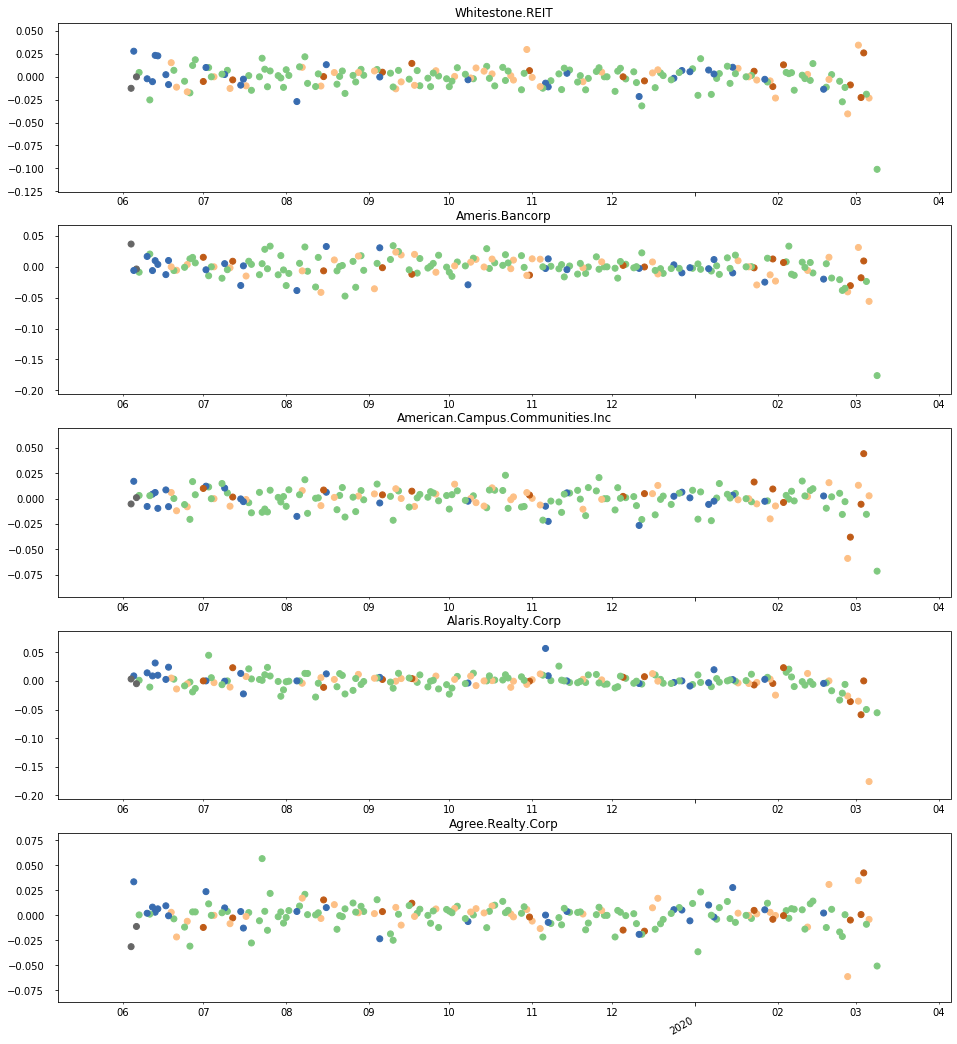

In [244]:
# read data
df = r
df = df.iloc[::-1]
df.index = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

year = mdates.YearLocator()
month = mdates.MonthLocator()


plt.rcParams['figure.figsize'] = (16, 20)
fig, ax = plt.subplots(5,1)
axes = ax.flatten()
axes[0].scatter(df.index, df.iloc[:,1], c=clusters1, cmap=plt.get_cmap('Accent'))
axes[0].set_title('Whitestone.REIT')
mafmt = mdates.DateFormatter("%Y")
axes[0].xaxis.set_major_locator(year)
axes[0].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[0].xaxis.set_minor_locator(month)
axes[0].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
#plt.xlabel('Date')
#plt.ylabel('CFLD')
axes[0].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[1].scatter(df.index, df.iloc[:,2], c=clusters1, cmap=plt.get_cmap('Accent'))
axes[1].set_title('Ameris.Bancorp')
mafmt = mdates.DateFormatter("%Y")
axes[1].xaxis.set_major_locator(year)
axes[1].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[1].xaxis.set_minor_locator(month)
axes[1].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
#plt.xlabel('Date')
#plt.ylabel('GG')
axes[1].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[2].scatter(df.index, df.iloc[:,3], c=clusters1, cmap=plt.get_cmap('Accent'))
axes[2].set_title('American.Campus.Communities.Inc')
mafmt = mdates.DateFormatter("%Y")
axes[2].xaxis.set_major_locator(year)
axes[2].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[2].xaxis.set_minor_locator(month)
axes[2].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
#plt.xlabel('Date')
#plt.ylabel('CV')
axes[2].tick_params(pad=10)


axes[3].scatter(df.index, df.iloc[:,4], c=clusters1, cmap=plt.get_cmap('Accent'))
axes[3].set_title('Alaris.Royalty.Corp')
mafmt = mdates.DateFormatter("%Y")
axes[3].xaxis.set_major_locator(year)
axes[3].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[3].xaxis.set_minor_locator(month)
axes[3].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
#plt.xlabel('Date')
#plt.ylabel('BRC')
axes[3].tick_params(pad=10)

axes[4].scatter(df.index, df.iloc[:,5], c=clusters1, cmap=plt.get_cmap('Accent'))
axes[4].set_title('Agree.Realty.Corp')
mafmt = mdates.DateFormatter("%Y")
axes[4].xaxis.set_major_locator(year)
axes[4].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[4].xaxis.set_minor_locator(month)
axes[4].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
#plt.xlabel('Date')
#plt.ylabel('CPGC')
axes[4].tick_params(pad=10)


plt.savefig('log_return.png',transparent=True)


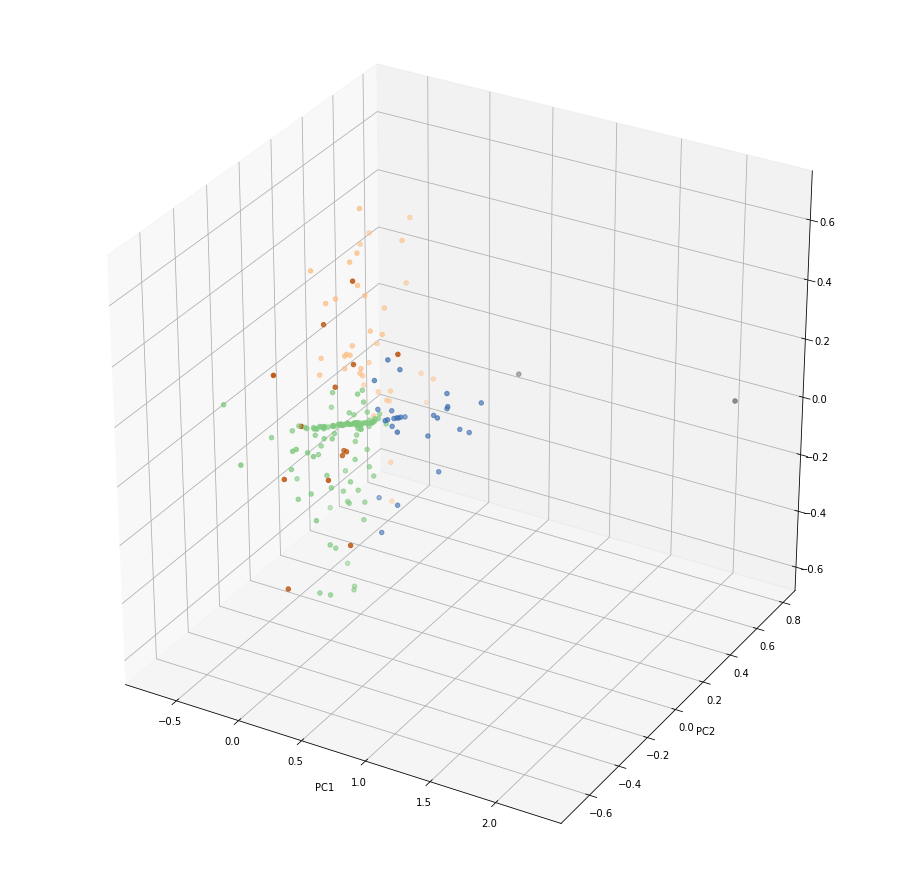

In [245]:
plt.rcParams['figure.figsize'] = (16, 16)
fig = plt.figure()

#year = mdates.YearLocator()
#month = mdates.MonthLocator()

ax = fig.add_subplot(111, projection='3d')
ax.scatter( X[:,0], X[:,1], X[:,2],c=clusters1, cmap=plt.get_cmap('Accent'))
#mafmt = mdates.DateFormatter("%Y")
#ax.xaxis.set_major_locator(year)
#ax.xaxis.set_major_formatter(mafmt)

#mifmt = mdates.DateFormatter("%m")
#ax.xaxis.set_minor_locator(month)
#ax.xaxis.set_minor_formatter(mifmt)
#fig.autofmt_xdate()
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.zlabel('PC3')
#axes.tick_params(pad=10)
plt.savefig('log_return3D.png',transparent=True)

In [125]:
crix = pd.read_csv('crix.csv')
vcrix = pd.read_csv('vcrix.csv')

In [126]:
datev = vcrix['date']
v = vcrix['vcrix']
datec = crix['date']
c = crix['price']
crix_pd = pd.concat([datec, c], axis=1)
vcrix_pd= pd.concat([datev, v], axis=1)
crix_pd.set_index(['date','price'])
crix1 = crix_pd.loc[crix_pd['date'] >= '2014-11-28']
crix2 = crix1.reset_index(drop=True)
cvc_new = pd.concat([crix2, v], axis=1)
cvc = cvc_new.drop([1800,1801])
cvc_X = cvc.drop(['date'],axis =1)

In [127]:
cvc1 = cvc.loc[cvc['date'] >= '2017-01-02']
cvc2 = cvc1.reset_index(drop=True)
cvc_X1 = cvc2.drop(['date'],axis =1)

In [22]:
log_p = np.log(cvc['price'])
crix_r = np.diff(log_p)
crix_ret = pd.DataFrame({'log_ret': crix_r[:]})
dd = cvc['date'].drop([0],axis =0)
dd1 = dd.reset_index(drop=True)
v1 = cvc['vcrix'].drop([0], axis =0)
v2 = v1/(np.std(v1))
v2 = v2.reset_index(drop=True)
crc = pd.concat([dd1,crix_ret, v2], axis=1)
crc_X = crc.drop(['date'],axis =1)

In [110]:
#C_q0 = pd.read_csv('Kquantile.csv')
#C_q = np.array(C_q0['x'])

In [111]:
#recession = pd.read_csv('recession.csv')

In [223]:
#recession.loc[recession['RECPROUSM156N']>0.18]

,DATE,RECPROUSM156N
7,2017-02-01,0.28
18,2018-01-01,0.28
22,2018-05-01,0.28
30,2019-01-01,0.26
31,2019-02-01,0.72
32,2019-03-01,0.54
33,2019-04-01,0.70
34,2019-05-01,0.34
35,2019-06-01,0.22
38,2019-09-01,1.06


In [128]:
cvc2.head()

,date,price,vcrix
0,2017-01-02,1777.585922,414.180445
1,2017-01-03,1815.817644,412.343105
2,2017-01-04,1987.193120,411.799455
3,2017-01-05,1751.581785,505.937128
4,2017-01-06,1593.464083,904.132860


In [154]:
from sklearn.preprocessing import StandardScaler
#standardize the data
Std_cvc = StandardScaler().fit_transform(cvc_X1)
#Std_cvc1= pd.read_csv('Scal_cvc.csv')
#Std_cvc2 = pd.concat([Std_cvc1['x1'], Std_cvc1['x2']], axis=1)
Std_cvc = np.array(Std_cvc)

k = 3
C_e, clusters_e = k_expectile_vtau(Std_cvc,k)


0.31529277414665435
0.19171908327091114
0.06458301759931587
0.053419701889478095
0.05457643100593673
0.054308794429351
0.05349573680824059
0.029381254212411095
0.0240419241712225
0.01491844487910436
0.014496802986499354
0.009786183978181425
0.005606657836397099
0.005606657836397099
0.005606657836397099
0.005606657836397099
0.005606657836397099
0.005606657836397099
0.005606657836397099
0.005606657836397099


In [81]:
tau = [0.5,0.5]
C_eu, clusters_eu = k_expectile_utau(Std_cvc, k, tau)

In [155]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(Std_cvc)
clusters_m = kmeans.labels_
C_m = kmeans.cluster_centers_

In [156]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=k)
spectral.fit(Std_cvc)
clusters_s = spectral.labels_

In [135]:
df1= pd.DataFrame(clusters_e, columns=['k-expectiles']) 
df2 = pd.DataFrame(clusters_m, columns=['k-means'])
cvc_clusters= pd.concat([cvc2,df1,df2],axis=1)
#cvc_clusters.to_csv('cvc_clusters.csv')

In [136]:
cvc_clusters.head()

,date,price,vcrix,k-expectiles,k-means
0,2017-01-02,1777.585922,414.180445,2.0,3
1,2017-01-03,1815.817644,412.343105,2.0,3
2,2017-01-04,1987.193120,411.799455,2.0,3
3,2017-01-05,1751.581785,505.937128,2.0,3
4,2017-01-06,1593.464083,904.132860,2.0,3


In [164]:
#matching cluster index
import itertools
def cluster_index(clusters, target, k):
    list_p = list(range(0,k,1))
    permu = list(itertools.permutations(list_p,k))
    new = np.zeros(clusters.shape)
    acc = np.zeros(len(permu))
    for i in range(len(permu)):
        for j in range(0,k,1):
            new[np.where(clusters == j)] = permu[i][j]
        acc[i] = np.sum(new == target)/len(target)
    index = permu[np.argmax(acc)]
    #print(index)
    return index, np.max(acc)

In [165]:
#clusters_q = C_q-1
index1,acc1 = cluster_index(clusters_e,clusters_m,k)
new1 = np.zeros(len(clusters_e))
for j in range(k):
    new1[np.where(clusters_e == j)] = index1[j]

index2,acc2 = cluster_index(clusters_s,clusters_m,k)
new2 = np.zeros(len(clusters_s))
for j in range(k):
    new2[np.where(clusters_s == j)] = index2[j]

In [149]:
new1,clusters_m,acc1
new2,clusters_m,acc2

(array([2., 2., 2., ..., 3., 3., 3.]),
 array([2, 2, 2, ..., 0, 0, 0], dtype=int32),
 0.4348191757779647)

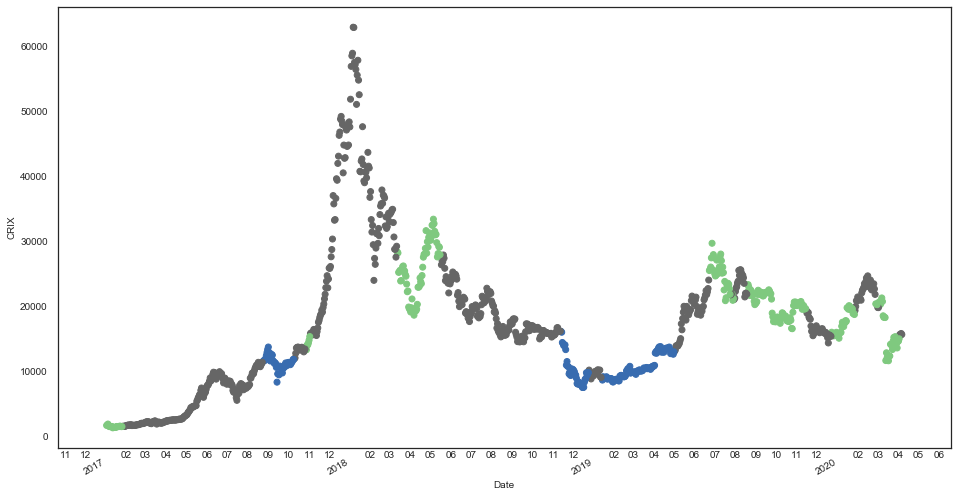

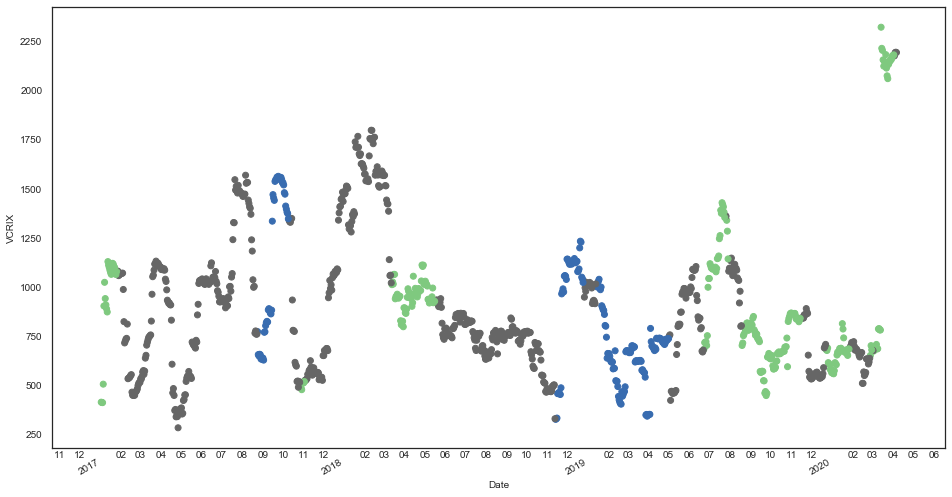

In [159]:
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib import rc

# read data
df = cvc1
df = df.iloc[::-1]
df.index = pd.to_datetime(df.date, yearfirst=True)

year = mdates.YearLocator()
month = mdates.MonthLocator()

fig, ax = plt.subplots(figsize = (16,9))
ax.scatter(df.index, df.price.values, c=new1, cmap=plt.get_cmap('Accent'))
mafmt = mdates.DateFormatter("%Y")
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
ax.xaxis.set_minor_locator(month)
ax.xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
ax.tick_params(pad=10)
#plt.savefig('crix4-kexpectile.png',transparent=True)


fig, ax = plt.subplots(figsize = (16,9))
ax.scatter(df.index, df.vcrix.values, c=new1, cmap=plt.get_cmap('Accent'))
mafmt = mdates.DateFormatter("%Y")
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
ax.xaxis.set_minor_locator(month)
ax.xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
ax.tick_params(pad=10)
#plt.savefig('vcrix4-kexpectile.png',transparent=True)

#plt.rcParams['figure.figsize'] = (16, 9)
#plt.scatter(df.iloc[:,1], df.iloc[:,2], c= clusters_c1)
#plt.scatter(C_c1[:,0], C_c1[:,1],marker='*', s=200, c='#050505')
#plt.savefig('two0.6.png',transparent=True)




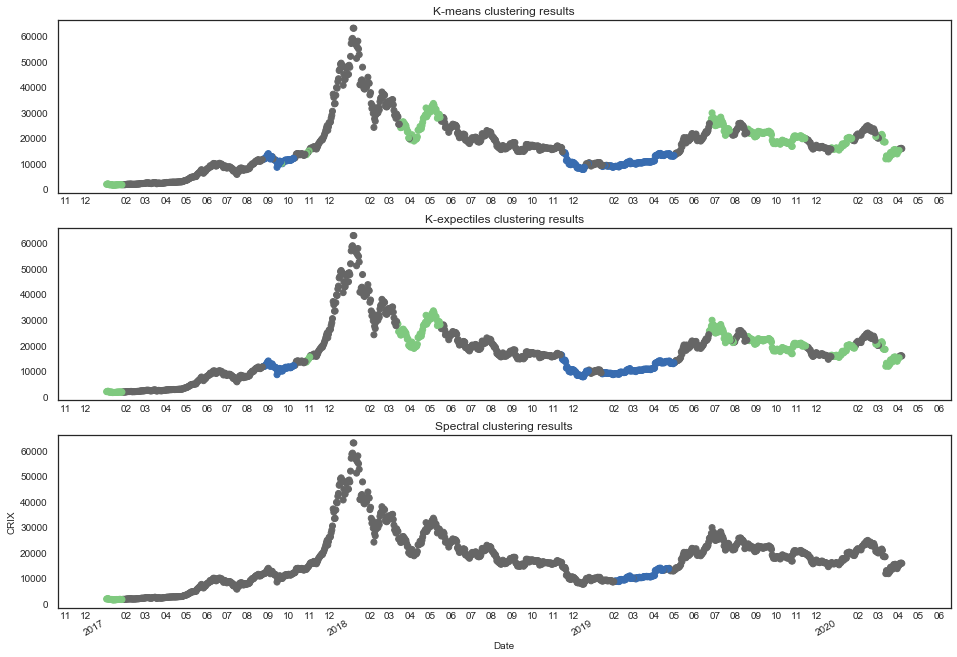

In [166]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(3,1)
axes = ax.flatten()
axes[0].scatter(df.index, df.price.values, c=clusters_m, cmap=plt.get_cmap('Accent'))
axes[0].set_title('K-means clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[0].xaxis.set_major_locator(year)
axes[0].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[0].xaxis.set_minor_locator(month)
axes[0].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
axes[0].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[1].scatter(df.index, df.price.values, c=new1, cmap=plt.get_cmap('Accent'))
axes[1].set_title('K-expectiles clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[1].xaxis.set_major_locator(year)
axes[1].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[1].xaxis.set_minor_locator(month)
axes[1].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
axes[1].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[2].scatter(df.index, df.price.values, c=new2, cmap=plt.get_cmap('Accent'))
axes[2].set_title('Spectral clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[2].xaxis.set_major_locator(year)
axes[2].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[2].xaxis.set_minor_locator(month)
axes[2].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('CRIX')
axes[2].tick_params(pad=10)
plt.savefig('crix3-compare.png',transparent=True)

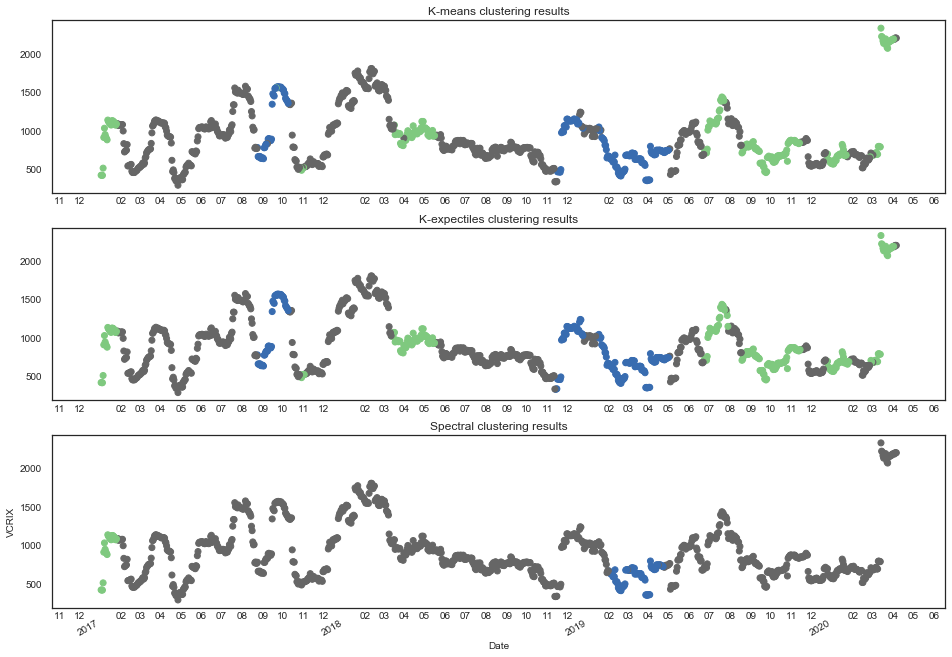

In [167]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(3,1)
axes = ax.flatten()
axes[0].scatter(df.index, df.vcrix.values, c=clusters_m, cmap=plt.get_cmap('Accent'))
axes[0].set_title('K-means clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[0].xaxis.set_major_locator(year)
axes[0].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[0].xaxis.set_minor_locator(month)
axes[0].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
axes[0].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[1].scatter(df.index, df.vcrix.values, c=new1, cmap=plt.get_cmap('Accent'))
axes[1].set_title('K-expectiles clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[1].xaxis.set_major_locator(year)
axes[1].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[1].xaxis.set_minor_locator(month)
axes[1].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
axes[1].tick_params(pad=10)

#fig, ax = plt.subplots(figsize = (16,9))
#fig, ax = plt.subplots(3,1)
axes[2].scatter(df.index, df.vcrix.values, c=new2, cmap=plt.get_cmap('Accent'))
axes[2].set_title('Spectral clustering results')
mafmt = mdates.DateFormatter("%Y")
axes[2].xaxis.set_major_locator(year)
axes[2].xaxis.set_major_formatter(mafmt)

mifmt = mdates.DateFormatter("%m")
axes[2].xaxis.set_minor_locator(month)
axes[2].xaxis.set_minor_formatter(mifmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('VCRIX')
axes[2].tick_params(pad=10)
plt.savefig('vcrix3-compare.png',transparent=True)

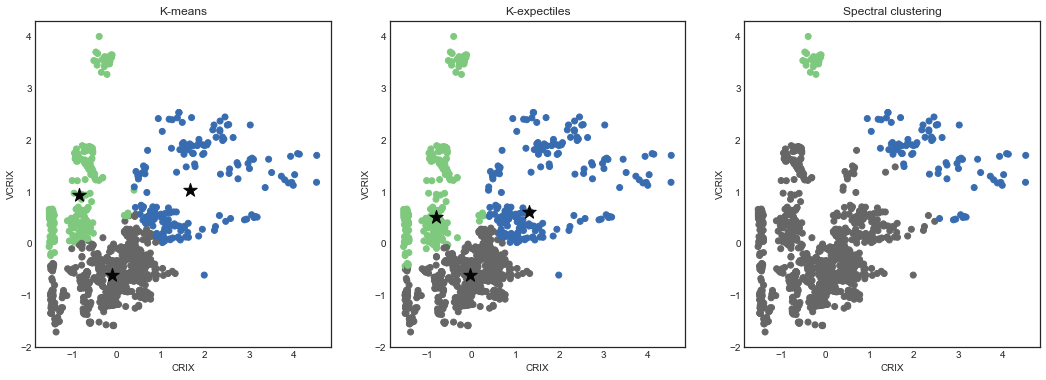

In [168]:
plt.rcParams['figure.figsize'] = (18,6)
plt.subplot(131)
#plt.scatter( df.price.values, df.vcrix.values,c= clusters2, cmap=plt.get_cmap('Set1'))
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= clusters_m, cmap=plt.get_cmap('Accent'))
plt.scatter(C_m[:,0], C_m[:,1],marker='*', s=200, c='#050505')
plt.xlabel('CRIX')
plt.ylabel('VCRIX')
plt.title('K-means')


plt.subplot(132)
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= new1, cmap=plt.get_cmap('Accent'))
plt.scatter(C_e[:,0], C_e[:,1],marker='*', s=200, c='#050505')
plt.xlabel('CRIX')
plt.ylabel('VCRIX')
plt.title('K-expectiles')


plt.subplot(133)
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= new2, cmap=plt.get_cmap('Accent'))
plt.xlabel('CRIX')
plt.ylabel('VCRIX')
plt.title('Spectral clustering')
plt.savefig('data_view3.png',transparent=True)

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('rainbow')
new_cmap_lower = truncate_colormap(cmap, 0, 0.5)
new_cmap_upper = truncate_colormap(cmap, 0.5, 1)


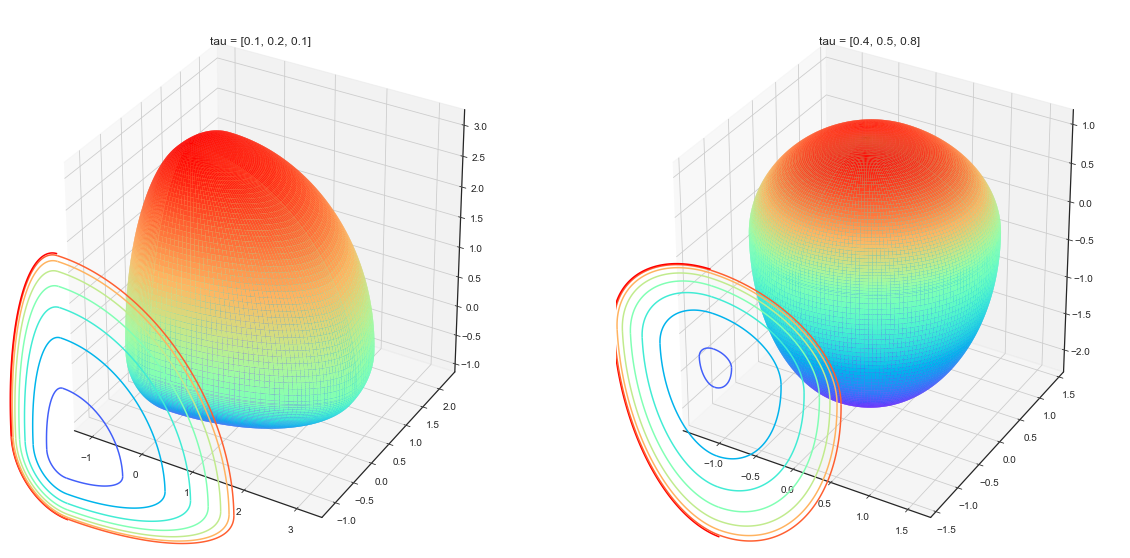

In [120]:
from mpl_toolkits.mplot3d import Axes3D


#plt.rcParams['figure.figsize'] = (9, 9)
plt.style.use('seaborn-white')



fig = plt.figure(figsize=(20, 10))  # Square figure
ax = fig.add_subplot(121, projection='3d')


# Make data
a,b,c= 0.1, 0.2, 0.1 # Coefficients in a x**2 + b y**2 + c z**2 = 1


u1 = np.linspace(0, 1/2 * np.pi, 100)
u2 = np.linspace(1/2 * np.pi, np.pi, 100)
u3 = np.linspace(np.pi, 3/2 *np.pi, 100)
u4 = np.linspace(3/2 *np.pi, 2 *np.pi, 100)
u  = np.linspace(0, 2* np.pi, 100)
v1 = np.linspace(0, 1/2* np.pi, 100)
v2 = np.linspace(np.pi, 3/2*np.pi, 100)

x1 =  a **(-1/2) * np.outer(np.cos(u1), np.sin(v1))
x2 =  (1-a)**(-1/2) * np.outer(np.cos(u2), np.sin(v1))
x3 =  (1-a)**(-1/2) * np.outer(np.cos(u3), np.sin(v1))
x4 =  a **(-1/2) * np.outer(np.cos(u4), np.sin(v1))

y1 =  b **(-1/2) * np.outer(np.sin(u1), np.sin(v1))
y2 =  b **(-1/2) * np.outer(np.sin(u2), np.sin(v1))
y3 = (1-b)**(-1/2) * np.outer(np.sin(u3), np.sin(v1))
y4 = (1-b)**(-1/2) * np.outer(np.sin(u4), np.sin(v1))

z1 = c**(-1/2) * np.outer(np.ones(np.size(u1)), np.cos(v1))
z2 = (1-c)**(-1/2) * np.outer(np.ones(np.size(u3)), np.cos(v2))


# Plot the surface
ax.plot_surface(x1, y1, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x2, y2, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x3, y3, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x4, y4, z1, color='b',cmap=new_cmap_upper)
ax.plot_surface(x1, y1, z2, color='b',cmap=new_cmap_lower)
ax.plot_surface(x2, y2, z2, color='b',cmap=new_cmap_lower)
ax.plot_surface(x3, y3, z2, color='b',cmap=new_cmap_lower)
ax.plot_surface(x4, y4, z2, color='b',cmap=new_cmap_lower)


#contour lines
ax.contour(x3, y3, z1, zdir='y', offset= -np.pi, cmap='rainbow')
ax.contour(x4, y4, z1, zdir='y', offset= -np.pi, cmap='rainbow')
ax.contour(x3, y3, z2, zdir='y', offset= -np.pi, cmap='rainbow')
ax.contour(x4, y4, z2, zdir='y', offset= -np.pi, cmap='rainbow')
ax.set_title('tau = [0.1, 0.2, 0.1]')
#ax.set_xlim3d(-np.pi, 2*np.pi);
#ax.set_ylim3d(0, 3*np.pi);
#ax.set_zlim3d(-np.pi, 2*np.pi);
   

ax1 = fig.add_subplot(122, projection='3d')
#plt.savefig('cluster shape0.9.png',transparent=True)

a,b,c= 0.4, 0.5, 0.8 # Coefficients in a x**2 + b y**2 + c z**2 = 1

u1 = np.linspace(0, 1/2 * np.pi, 100)
u2 = np.linspace(1/2 * np.pi, np.pi, 100)
u3 = np.linspace(np.pi, 3/2 *np.pi, 100)
u4 = np.linspace(3/2 *np.pi, 2 *np.pi, 100)
u  = np.linspace(0, 2* np.pi, 100)
v1 = np.linspace(0, 1/2* np.pi, 100)
v2 = np.linspace(np.pi, 3/2*np.pi, 100)

x1 =  a **(-1/2) * np.outer(np.cos(u1), np.sin(v1))
x2 =  (1-a)**(-1/2) * np.outer(np.cos(u2), np.sin(v1))
x3 =  (1-a)**(-1/2) * np.outer(np.cos(u3), np.sin(v1))
x4 =  a **(-1/2) * np.outer(np.cos(u4), np.sin(v1))

y1 =  b **(-1/2) * np.outer(np.sin(u1), np.sin(v1))
y2 =  b **(-1/2) * np.outer(np.sin(u2), np.sin(v1))
y3 = (1-b)**(-1/2) * np.outer(np.sin(u3), np.sin(v1))
y4 = (1-b)**(-1/2) * np.outer(np.sin(u4), np.sin(v1))

z1 = c**(-1/2) * np.outer(np.ones(np.size(u1)), np.cos(v1))
z2 = (1-c)**(-1/2) * np.outer(np.ones(np.size(u3)), np.cos(v2))


# Plot the surface
ax1.plot_surface(x1, y1, z1, color='b',cmap=new_cmap_upper)
ax1.plot_surface(x2, y2, z1, color='b',cmap=new_cmap_upper)
ax1.plot_surface(x3, y3, z1, color='b',cmap=new_cmap_upper)
ax1.plot_surface(x4, y4, z1, color='b',cmap=new_cmap_upper)
ax1.plot_surface(x1, y1, z2, color='b',cmap=new_cmap_lower)
ax1.plot_surface(x2, y2, z2, color='b',cmap=new_cmap_lower)
ax1.plot_surface(x3, y3, z2, color='b',cmap=new_cmap_lower)
ax1.plot_surface(x4, y4, z2, color='b',cmap=new_cmap_lower)


#contour lines
ax1.contour(x3, y3, z1, zdir='y', offset= -np.pi, cmap='rainbow')
ax1.contour(x4, y4, z1, zdir='y', offset= -np.pi, cmap='rainbow')
ax1.contour(x3, y3, z2, zdir='y', offset= -np.pi, cmap='rainbow')
ax1.contour(x4, y4, z2, zdir='y', offset= -np.pi, cmap='rainbow')
ax1.set_title('tau = [0.4, 0.5, 0.8]')

plt.savefig('3D_various_tau.png',transparent=True)

In [87]:
def clu_shape(cov,taus):
    Sample = np.random.multivariate_normal([0, 0], cov, 1000)
    [c1,c2] = expectile_fun(Sample, taus)
    
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x,y)
    F = X**2 + 1/cov[1][1]*(Y)**2 - 1


    u1 = np.linspace(0, 1, 100)+c1
    u2 = np.linspace(-1, 0, 100)+c1

    v1 = np.linspace(0, 1, 100)+c2
    v2 = np.linspace(-1, 0, 100)+c2


    a,b = taus[0],taus[1]


    X1,Y1 = np.meshgrid(u1,v1)
    X2,Y2 = np.meshgrid(u2,v1)
    X3,Y3 = np.meshgrid(u2,v2)
    X4,Y4 = np.meshgrid(u1,v2)

    F1 = 1/cov[0][0]*(a **(-1/2) * (X1-c1))**2 + 1/cov[1][1]*(b **(-1/2) *(Y1-c2))**2 - 1
    F2 = 1/cov[0][0]*((1-a) **(-1/2) * (X2-c1))**2 + 1/cov[1][1]*(b **(-1/2) *(Y2-c2))**2 - 1
    F3 = 1/cov[0][0]*((1-a) **(-1/2) * (X3-c1))**2 + 1/cov[1][1]*((1-b) **(-1/2) *(Y3-c2))**2 - 1
    F4 = 1/cov[0][0]*(a **(-1/2) * (X4-c1))**2 + 1/cov[1][1]*((1-b) **(-1/2) *(Y4-c2))**2 - 1
    
    plt.xlim(-1.9,1.9)
    plt.ylim(-1.9,1.9)
    plt.contour(X,Y,F,[0],colors='purple')
    plt.contour(X1,Y1,F1,[0],colors='purple')
    plt.contour(X2,Y2,F2,[0],colors='purple')
    plt.contour(X3,Y3,F3,[0],colors='purple')
    plt.contour(X4,Y4,F4,[0],colors='purple')
    plt.scatter(c1, c2,marker='*', s=400, c='#050505')
    return plt



Text(0.5, 1.0, 'cov=[[1,0],[0,0.5]], tau = [0.2,0.8]')

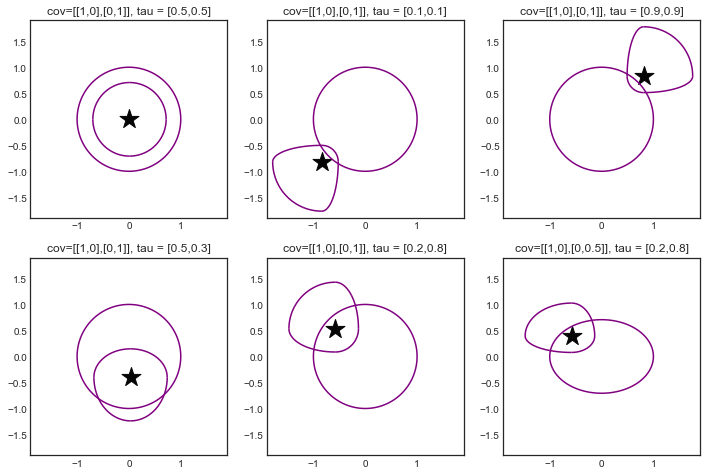

In [88]:
plt.rcParams['figure.figsize'] = (12, 8)

plt.subplot(231)
cov1 = [[1, 0], [0, 1]]
taus1 = [0.5, 0.5]
clu_shape(cov1,taus1)
plt.title('cov=[[1,0],[0,1]], tau = [0.5,0.5]')

plt.subplot(232)
cov1 = [[1, 0], [0, 1]]
taus1 = [0.1, 0.1]
clu_shape(cov1,taus1)
plt.title('cov=[[1,0],[0,1]], tau = [0.1,0.1]')

plt.subplot(233)
cov1 = [[1, 0], [0, 1]]
taus1 = [0.9, 0.9]
clu_shape(cov1,taus1)
plt.title('cov=[[1,0],[0,1]], tau = [0.9,0.9]')

plt.subplot(234)
cov1 = [[1, 0], [0, 1]]
taus1 = [0.5, 0.3]
clu_shape(cov1,taus1)
plt.title('cov=[[1,0],[0,1]], tau = [0.5,0.3]')

plt.subplot(235)
cov1 = [[1, 0], [0, 1]]
taus1 = [0.2, 0.8]
clu_shape(cov1,taus1)
plt.title('cov=[[1,0],[0,1]], tau = [0.2,0.8]')

plt.subplot(236)
cov1 = [[1, 0], [0, 0.5]]
taus1 = [0.2, 0.8]
clu_shape(cov1,taus1)
plt.title('cov=[[1,0],[0,0.5]], tau = [0.2,0.8]')

#plt.savefig('various_taus.png',transparent=True)

In [93]:
def clusters(cov,taus,l1,l2):
    Sample = np.random.multivariate_normal([0, 0], cov, 1000)
    [d1,d2] = expectile_fun(Sample, taus)
    c1 = d1 + l1
    c2 = d2 + l2
    #plt.rcParams['figure.figsize'] = (11, 11)
    #plt.figure()

    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x,y)



    u1 = np.linspace(0, 1, 100)+c1
    u2 = np.linspace(-1, 0, 100)+c1

    v1 = np.linspace(0, 1, 100)+c2
    v2 = np.linspace(-1, 0, 100)+c2


    a,b = taus[0],taus[1]


    X1,Y1 = np.meshgrid(u1,v1)
    X2,Y2 = np.meshgrid(u2,v1)
    X3,Y3 = np.meshgrid(u2,v2)
    X4,Y4 = np.meshgrid(u1,v2)

    F1 = 1/cov[0][0]*(a **(-1/2) * (X1-c1))**2 + 1/cov[1][1]*(b **(-1/2) *(Y1-c2))**2 - 1
    F2 = 1/cov[0][0]*((1-a) **(-1/2) * (X2-c1))**2 + 1/cov[1][1]*(b **(-1/2) *(Y2-c2))**2 - 1
    F3 = 1/cov[0][0]*((1-a) **(-1/2) * (X3-c1))**2 + 1/cov[1][1]*((1-b) **(-1/2) *(Y3-c2))**2 - 1
    F4 = 1/cov[0][0]*(a **(-1/2) * (X4-c1))**2 + 1/cov[1][1]*((1-b) **(-1/2) *(Y4-c2))**2 - 1

    #plt.xlim(-1.5,1.5)
    #plt.ylim(-1.5,1.5)

    plt.contour(X1,Y1,F1,[0],colors='purple')
    plt.contour(X2,Y2,F2,[0],colors='purple')
    plt.contour(X3,Y3,F3,[0],colors='purple')
    plt.contour(X4,Y4,F4,[0],colors='purple')
    plt.scatter(c1, c2,marker='*', s=400, c='#050505')
    return plt

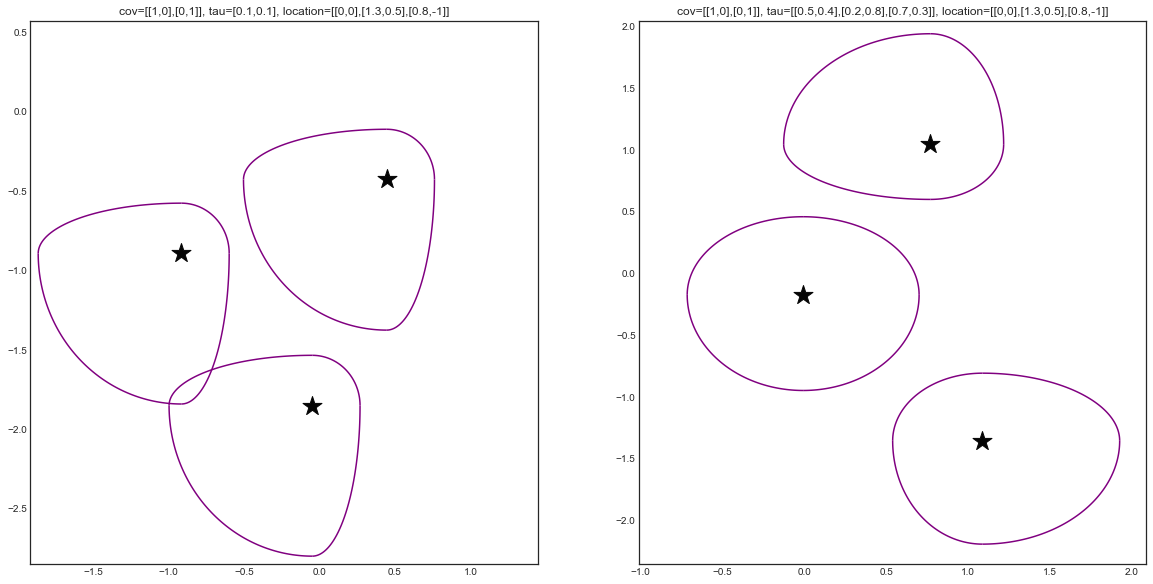

In [122]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.subplot(121)
cov1 = [[1, 0], [0, 1]]
taus1 = [0.1, 0.1]
clusters(cov1,taus1,0,0)
clusters(cov1,taus1,1.3,0.5)
clusters(cov1,taus1,0.8,-1)
plt.title('cov=[[1,0],[0,1]], tau=[0.1,0.1], location=[[0,0],[1.3,0.5],[0.8,-1]]')


plt.subplot(122)
cov1 = [[1, 0], [0, 1]]
taus2 = [0.5, 0.4]
clusters(cov1,taus2,0,0)
taus3 = [0.2, 0.8]
clusters(cov1,taus3,1.3,0.5)
taus4 = [0.7, 0.3]
clusters(cov1,taus4,0.8,-1)
plt.title('cov=[[1,0],[0,1]], tau=[[0.5,0.4],[0.2,0.8],[0.7,0.3]], location=[[0,0],[1.3,0.5],[0.8,-1]]')

plt.savefig('clusters.png',transparent=True)

In [107]:
from sklearn import metrics
silhouette =  list()
calinski =  list()
for k in range(2,15):
    C_c1, clusters1 = k_expectile_new(Std_cvc,k)
    s1 = metrics.silhouette_score(Std_cvc, clusters1, metric='euclidean')
    print(s1)
    s2 = metrics.calinski_harabaz_score(Std_cvc, clusters1)
    print(s2)
    calinski.append(s2)
    silhouette.append(s1)

[[0.46838156 0.528403  ]
 [0.46153846 0.50699301]]
0.08193433726651439
[[0.46583354 0.54408855]
 [0.44058632 0.51076657]]
0.04166313540095317
[[0.46431759 0.55234243]
 [0.43672623 0.51134264]]
0.014163586445249381
0.4379074800377499
892.231354081446
[[0.38987342 0.47088608]
 [0.45       0.58      ]
 [0.5441989  0.46961326]]
0.1581007650458543
[[0.29370465 0.46294765]
 [0.44076024 0.63777036]
 [0.57514786 0.4645112 ]]
0.09689033088699285
[[0.21628988 0.46576491]
 [0.43167096 0.66481288]
 [0.5817616  0.44577702]]
0.05359719843658422
[[0.17696321 0.47911269]
 [0.40699145 0.66179989]
 [0.58323025 0.43516788]]
0.05970783048203726
[[0.15663945 0.48765931]
 [0.38507774 0.67008831]
 [0.57750711 0.42911606]]
0.05075399527191621
[[0.14562191 0.49907369]
 [0.36425706 0.6775889 ]
 [0.57896185 0.41947084]]
0.05244362616756399
[[0.14680846 0.51982193]
 [0.35258112 0.68022287]
 [0.56196362 0.40792672]]
0.07838130392173046
[[0.16594536 0.52748823]
 [0.35425088 0.67442461]
 [0.5510697  0.40939278]]
0.0

[[0.62184484 0.51218162]
 [0.53898638 0.61913574]
 [0.38013439 0.34676649]
 [0.03302989 0.55064601]
 [0.35910547 0.49504042]
 [0.29302874 0.6291396 ]
 [0.36280488 0.66413374]]
0.0452109051129645
[[0.63662196 0.47701002]
 [0.53887758 0.62202193]
 [0.38013439 0.34676649]
 [0.03234704 0.57738501]
 [0.36208378 0.49904087]
 [0.2983928  0.64415115]
 [0.36280488 0.66413374]]
0.047706247729724933
[[0.65063144 0.44233223]
 [0.5418438  0.61803654]
 [0.38013439 0.34676649]
 [0.03766047 0.58480228]
 [0.355193   0.50543899]
 [0.2983928  0.64415115]
 [0.36280488 0.66413374]]
0.021202379319820313
0.4211082269424962
1219.405188102884
[[0.4        0.65714286]
 [0.50393701 0.56692913]
 [0.56510639 0.51658192]
 [0.48175182 0.44525547]
 [0.45098039 0.43137255]
 [0.48943346 0.58755171]
 [0.31282051 0.51794872]
 [0.23611111 0.55555556]]
0.2237915907200188
[[0.33333333 0.66990291]
 [0.50787353 0.59760221]
 [0.60446384 0.50199632]
 [0.47711062 0.41570706]
 [0.38013439 0.40295805]
 [0.4837955  0.63047281]
 [0.

[[0.44230769 0.44230769]
 [0.45185185 0.51111111]
 [0.23880597 0.56716418]
 [0.28125    0.421875  ]
 [0.46236559 0.47311828]
 [0.37398374 0.5203252 ]
 [0.42857143 0.47058824]
 [0.42424242 0.63636364]
 [0.57051282 0.54487179]
 [0.31111111 0.47777778]
 [0.52307692 0.53076923]]
0.2173331657940829
[[0.38213762 0.40562602]
 [0.39246422 0.51359671]
 [0.2699476  0.65125127]
 [0.17327566 0.37948569]
 [0.43805259 0.46301124]
 [0.39956714 0.52014859]
 [0.40509572 0.47760529]
 [0.3518851  0.65027322]
 [0.60504735 0.56057211]
 [0.22342174 0.50549496]
 [0.51434441 0.54839051]]
0.08905533234608617
[[0.39445491 0.3552168 ]
 [0.36233195 0.51281258]
 [0.30948746 0.64500283]
 [0.13218898 0.35608936]
 [0.42572107 0.45252374]
 [0.42406369 0.51991317]
 [0.39189643 0.46261741]
 [0.3279351  0.67410366]
 [0.58636636 0.56349106]
 [0.16059429 0.50926083]
 [0.51827729 0.56006422]]
0.06280243299672848
[[0.39445491 0.33710357]
 [0.35535959 0.50523886]
 [0.29219346 0.63870454]
 [0.12823007 0.34928785]
 [0.42299169 

[[0.57411441 0.57734601]
 [0.37049947 0.47199285]
 [0.39490504 0.39102776]
 [0.14385241 0.42323276]
 [0.49706317 0.70507467]
 [0.25858554 0.47571481]
 [0.25645195 0.6475473 ]
 [0.50121226 0.62907549]
 [0.14035256 0.43132714]
 [0.54098522 0.41091618]
 [0.45766077 0.55852877]
 [0.17693529 0.50868854]
 [0.02119477 0.44694813]]
0.050359477910886005
[[0.56551284 0.58588486]
 [0.37049947 0.47199285]
 [0.39490504 0.35499719]
 [0.14047053 0.41581305]
 [0.49706317 0.70507467]
 [0.26492156 0.46754393]
 [0.25645195 0.6475473 ]
 [0.49810664 0.63196948]
 [0.13274497 0.43660987]
 [0.53513676 0.39393608]
 [0.45441802 0.55530311]
 [0.18577802 0.61708149]
 [0.02158604 0.44233241]]
0.04903198393641202
[[0.57411441 0.5943724 ]
 [0.37049947 0.47199285]
 [0.39490504 0.37280927]
 [0.14179588 0.42739406]
 [0.49706317 0.70507467]
 [0.25858554 0.45939042]
 [0.25645195 0.6475473 ]
 [0.50121226 0.62907549]
 [0.14035256 0.43132714]
 [0.54098522 0.41091618]
 [0.45766077 0.55852877]
 [0.16588654 0.55623555]
 [0.021

In [58]:
from sklearn import metrics
s1 = metrics.silhouette_score(Std_cvc, clusters_m, metric='euclidean')
s2 = metrics.silhouette_score(Std_cvc, clusters_e, metric='euclidean')
c1 = metrics.calinski_harabaz_score(Std_cvc, clusters_m)
c2 = metrics.calinski_harabaz_score(Std_cvc, clusters_e)
s1,s2
#c1,c2


(0.47558607187136215, 0.47295313159976166)

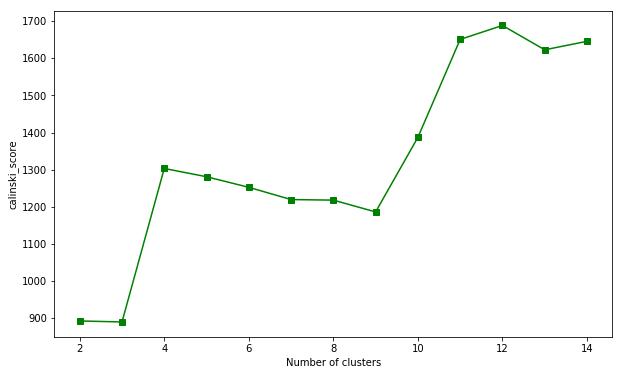

In [109]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(range(2,15), calinski,'g-s')
plt.xlabel('Number of clusters')
plt.ylabel('calinski_score')
plt.savefig('calinski.png',transparent=True)

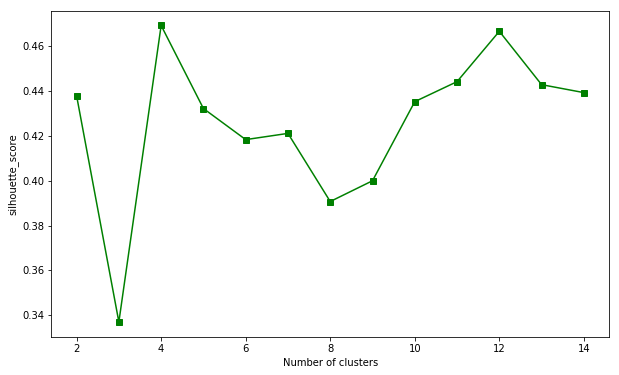

In [111]:
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(range(2,15), silhouette,'g-s')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette_score')
plt.savefig('silhouette.png',transparent=True)